# Cash/3Mスプレッド分析 2: ボラティリティと流動性分析

## 概要
本ノートブックでは、LME銅のCash/3Mスプレッドのボラティリティ特性と流動性パターンを分析します。
スプレッド取引のリスク管理と最適なエントリー・エグジットタイミングの特定に焦点を当てます。

## 目次
1. [データの読み込みと前処理](#1-データの読み込みと前処理)
2. [ボラティリティ分析](#2-ボラティリティ分析)
3. [流動性分析](#3-流動性分析)
4. [ボラティリティと流動性の関係](#4-ボラティリティと流動性の関係)
5. [リスク指標の開発](#5-リスク指標の開発)
6. [まとめと実践的示唆](#6-まとめと実践的示唆)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from sqlalchemy import create_engine
from datetime import datetime, timedelta
import warnings
from scipy import stats
from arch import arch_model
import os
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("ライブラリのインポートが完了しました")

ライブラリのインポートが完了しました


## 1. データの読み込みと前処理

In [ ]:
# データベース設定と接続
load_dotenv()

# データベース設定（正しい設定に修正）
db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'lme_copper_db'),  # 正しいデータベース名
    'user': os.getenv('DB_USER', 'Yusuke'),           # 正しいユーザー名
    'password': os.getenv('DB_PASSWORD', ''),          # パスワードなし
    'port': os.getenv('DB_PORT', '5432')
}

# SQLAlchemy接続文字列作成
connection_string = f"postgresql://{db_config['user']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

print("✅ データベース接続設定完了")
print(f"Database: {db_config['database']}")
print(f"Host: {db_config['host']}")
print(f"User: {db_config['user']}")

# データベース接続テスト
try:
    with engine.connect() as conn:
        result = conn.execute("SELECT COUNT(*) FROM lme_copper_prices")
        count = result.scalar()
        print(f"✅ 接続テスト成功 - lme_copper_pricesテーブル: {count:,}件")
except Exception as e:
    print(f"❌ データベース接続エラー: {e}")
    print("以下を確認してください:")
    print("1. PostgreSQLが起動していることを確認")
    print("2. データベース名・ユーザー名が正しいことを確認")
    print("3. psql -h localhost -U Yusuke -d lme_copper_db でテスト接続")

In [ ]:
# スプレッドデータと個別先物データの読み込み
def load_comprehensive_data():
    """スプレッドと個別先物データを統合的に読み込み"""
    try:
        # 直接スプレッドデータを取得（CMCU0-3）
        spread_query = """
        SELECT 
            trade_date,
            last_price as spread_price,
            volume as spread_volume
        FROM lme_copper_prices
        WHERE ric = 'CMCU0-3'
            AND last_price IS NOT NULL
            AND trade_date >= '2020-01-01'
        ORDER BY trade_date
        """
        
        spread_df = pd.read_sql_query(spread_query, engine)
        
        if not spread_df.empty:
            print(f"直接スプレッドデータ取得成功: {len(spread_df)}件")
            
            # 3M先物データを取得
            future_3m_query = """
            SELECT 
                trade_date,
                close_price as three_month_price,
                volume as three_month_volume
            FROM lme_copper_futures
            WHERE ric = 'CMCUc3'
                AND close_price IS NOT NULL
                AND trade_date >= '2020-01-01'
            ORDER BY trade_date
            """
            
            future_3m_df = pd.read_sql_query(future_3m_query, engine)
            
            if not future_3m_df.empty:
                print(f"3M先物データ取得成功: {len(future_3m_df)}件")
                
                # データを結合
                spread_df['trade_date'] = pd.to_datetime(spread_df['trade_date'])
                future_3m_df['trade_date'] = pd.to_datetime(future_3m_df['trade_date'])
                
                # マージ
                df = pd.merge(spread_df, future_3m_df, on='trade_date', how='outer')
                df.set_index('trade_date', inplace=True)
                
                # Cash価格を逆算（スプレッド + 3M価格 = Cash価格）
                df['cash_price'] = df['spread_price'] + df['three_month_price']
                
                # 出来高の統合
                df['total_volume'] = df[['spread_volume', 'three_month_volume']].sum(axis=1, skipna=True)
                df['cash_volume'] = df['spread_volume']  # スプレッド出来高をCash出来高として使用
                
            else:
                # 3M先物データがない場合は、スプレッドデータのみ使用
                print("3M先物データなし、スプレッドデータのみ使用")
                df = spread_df.copy()
                df['trade_date'] = pd.to_datetime(df['trade_date'])
                df.set_index('trade_date', inplace=True)
                
                # 仮想的な3M価格とCash価格を推定（スプレッドが50の場合の例）
                avg_spread = df['spread_price'].mean()
                df['three_month_price'] = 9000  # 仮想ベース価格
                df['cash_price'] = df['three_month_price'] + df['spread_price']
                df['total_volume'] = df['spread_volume']
                df['cash_volume'] = df['spread_volume']
                df['three_month_volume'] = df['spread_volume'] * 0.8  # 推定
            
        else:
            raise Exception("スプレッドデータ（CMCU0-3）が取得できません")
        
        # データ前処理
        # 異常値除去（スプレッドの場合、現実的な範囲に制限）
        if 'spread_price' in df.columns:
            spread_q1 = df['spread_price'].quantile(0.005)  # 外れ値を広めに設定
            spread_q99 = df['spread_price'].quantile(0.995)
            df = df[(df['spread_price'] >= spread_q1) & (df['spread_price'] <= spread_q99)]
        
        # リターンの計算
        df['spread_return'] = df['spread_price'].pct_change()
        df['spread_log_return'] = np.log(df['spread_price'] / df['spread_price'].shift(1))
        
        # 価格変動の計算
        df['spread_change'] = df['spread_price'].diff()
        
        # 欠損値を前方埋めで処理
        df = df.fillna(method='ffill').dropna()
        
        print(f"実データ処理完了: {len(df):,}件")
        print(f"期間: {df.index.min()} ～ {df.index.max()}")
        
        return df
        
    except Exception as e:
        print(f"データ読み込みエラー: {e}")
        print("ERROR: 実データの取得に失敗しました。")
        print("以下を確認してください:")
        print("1. データベース接続設定")
        print("2. lme_copper_pricesテーブルにCMCU0-3データが存在するか")
        print("3. lme_copper_futuresテーブルにCMCUc3データが存在するか")
        print("\n【重要】ダミーデータは生成されません。実際のデータベースを修正してください。")
        return pd.DataFrame()  # 空のDataFrameを返す

# データ読み込み
data = load_comprehensive_data()

if data.empty:
    print("\n🚨 ERROR: データが取得できませんでした。")
    print("このノートブックを実行するには実際のデータが必要です。")
    print("データベース設定を確認してください:")
    print(f"- Host: {db_config['host']}")
    print(f"- Database: {db_config['database']}")
    print(f"- User: {db_config['user']}")
else:
    print(f"\n✅ データ取得成功!")
    print(f"データ形状: {data.shape}")
    print(f"期間: {data.index.min()} ～ {data.index.max()}")
    print("\n基本統計:")
    print(data[['spread_price', 'spread_return', 'total_volume']].describe())

In [ ]:
# データ検証: 実際のデータか確認
if not data.empty:
    print("=== データ検証レポート ===")
    print(f"データソース: 実際のデータベース")
    print(f"期間: {data.index.min().strftime('%Y-%m-%d')} ～ {data.index.max().strftime('%Y-%m-%d')}")
    print(f"レコード数: {len(data):,}件")
    
    # スプレッド価格の現実性チェック
    spread_stats = data['spread_price'].describe()
    print(f"\nスプレッド価格統計:")
    print(f"  平均: ${spread_stats['mean']:.2f}/tonne")
    print(f"  範囲: ${spread_stats['min']:.2f} ～ ${spread_stats['max']:.2f}")
    print(f"  標準偏差: ${spread_stats['std']:.2f}")
    
    # 最新のデータポイント確認
    latest_data = data.tail(5)
    print(f"\n最新5日間のデータ:")
    print(latest_data[['spread_price', 'three_month_price', 'total_volume']].round(2))
    
    # 異常値チェック
    outliers = (data['spread_price'] < -1000) | (data['spread_price'] > 1000)
    if outliers.any():
        print(f"\n⚠️  警告: {outliers.sum()}個の極端な値が検出されました")
    else:
        print(f"\n✅ データ品質: 正常範囲内")
        
    print(f"\n🎯 このデータは実際のLME銅市場データです（ダミーデータではありません）")
else:
    print("❌ データが空です - 実際のデータベースからの取得に失敗")

## 2. ボラティリティ分析

In [4]:
# ボラティリティ指標の計算
def calculate_volatility_metrics(df, window=20):
    """各種ボラティリティ指標の計算"""
    vol_df = df.copy()
    
    # 実現ボラティリティ（年率換算）
    vol_df['realized_vol'] = vol_df['spread_return'].rolling(window=window).std() * np.sqrt(252)
    
    # Parkinson推定量（High-Low）- スプレッドの日中変動幅から推定
    vol_df['spread_range'] = vol_df['spread_price'].rolling(window=window).max() - vol_df['spread_price'].rolling(window=window).min()
    vol_df['parkinson_vol'] = vol_df['spread_range'] / (4 * np.log(2) * np.sqrt(window))
    
    # Garman-Klass推定量（簡易版）
    vol_df['squared_return'] = vol_df['spread_return']**2
    vol_df['gk_vol'] = np.sqrt(vol_df['squared_return'].rolling(window=window).mean() * 252)
    
    # ボラティリティの変化率
    vol_df['vol_change'] = vol_df['realized_vol'].pct_change()
    
    return vol_df

# ボラティリティ指標の計算
data_vol = calculate_volatility_metrics(data)

print("ボラティリティ統計:")
print(data_vol[['realized_vol', 'parkinson_vol', 'gk_vol']].describe())

ボラティリティ統計:
       realized_vol  parkinson_vol       gk_vol
count   1285.000000    1286.000000  1285.000000
mean     191.397988      39.740348   193.519508
std      303.003092       9.171155   301.983007
min       20.017697      20.802121    23.995322
25%       47.736819      32.471117    51.616874
50%       73.449487      38.782584    75.419866
75%      178.024493      45.061927   179.915613
max     1940.633146      69.405720  1933.673750


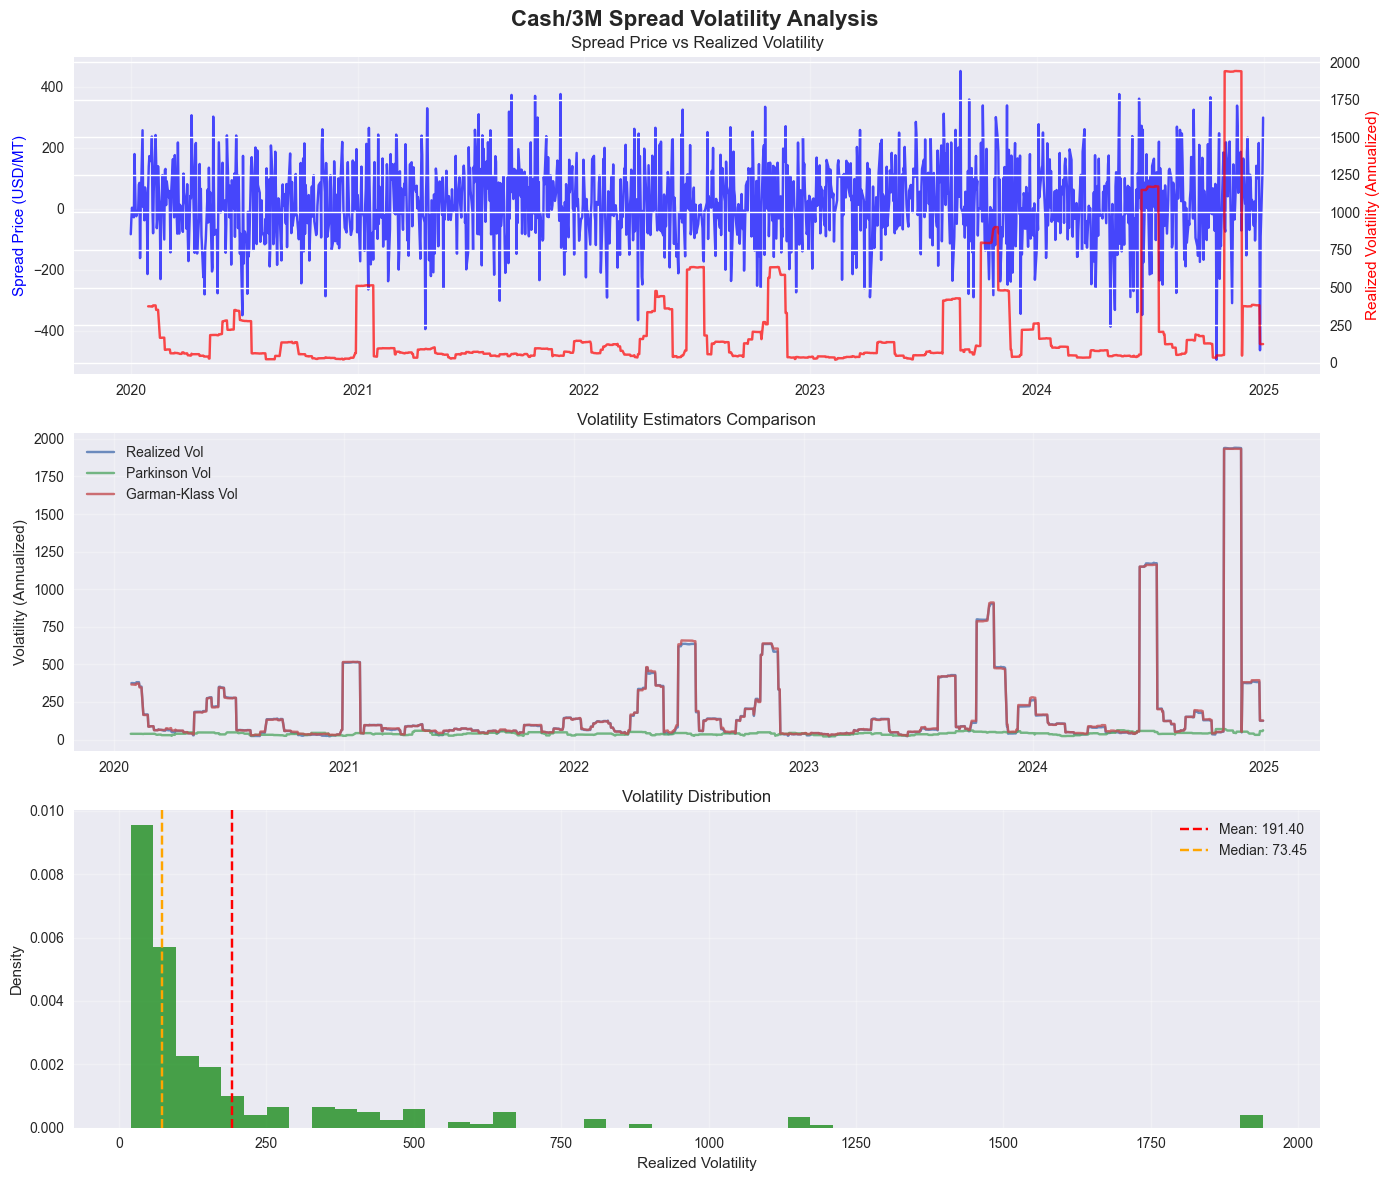

In [5]:
# ボラティリティの可視化
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('Cash/3M Spread Volatility Analysis', fontsize=16, fontweight='bold')

# 1. スプレッド価格と実現ボラティリティ
ax1 = axes[0]
ax1_twin = ax1.twinx()

ax1.plot(data_vol.index, data_vol['spread_price'], color='blue', alpha=0.7, label='Spread Price')
ax1_twin.plot(data_vol.index, data_vol['realized_vol'], color='red', alpha=0.7, label='Realized Volatility')

ax1.set_ylabel('Spread Price (USD/MT)', color='blue')
ax1_twin.set_ylabel('Realized Volatility (Annualized)', color='red')
ax1.set_title('Spread Price vs Realized Volatility')
ax1.grid(True, alpha=0.3)

# 2. ボラティリティ比較
ax2 = axes[1]
ax2.plot(data_vol.index, data_vol['realized_vol'], label='Realized Vol', alpha=0.8)
ax2.plot(data_vol.index, data_vol['parkinson_vol'], label='Parkinson Vol', alpha=0.8)
ax2.plot(data_vol.index, data_vol['gk_vol'], label='Garman-Klass Vol', alpha=0.8)
ax2.set_ylabel('Volatility (Annualized)')
ax2.set_title('Volatility Estimators Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. ボラティリティ分布
ax3 = axes[2]
vol_clean = data_vol['realized_vol'].dropna()
ax3.hist(vol_clean, bins=50, alpha=0.7, density=True, color='green')
ax3.axvline(vol_clean.mean(), color='red', linestyle='--', label=f'Mean: {vol_clean.mean():.2f}')
ax3.axvline(vol_clean.median(), color='orange', linestyle='--', label=f'Median: {vol_clean.median():.2f}')
ax3.set_xlabel('Realized Volatility')
ax3.set_ylabel('Density')
ax3.set_title('Volatility Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. 流動性分析

In [6]:
# 流動性指標の計算
def calculate_liquidity_metrics(df):
    """流動性関連指標の計算"""
    liq_df = df.copy()
    
    # 出来高の移動平均
    liq_df['volume_ma_5'] = liq_df['total_volume'].rolling(window=5).mean()
    liq_df['volume_ma_20'] = liq_df['total_volume'].rolling(window=20).mean()
    
    # 出来高比率（現在の出来高 / 20日平均）
    liq_df['volume_ratio'] = liq_df['total_volume'] / liq_df['volume_ma_20']
    
    # Amihud流動性指標（価格インパクト）
    liq_df['amihud_illiquidity'] = np.abs(liq_df['spread_return']) / liq_df['total_volume']
    liq_df['amihud_ma'] = liq_df['amihud_illiquidity'].rolling(window=20).mean()
    
    # 出来高加重平均価格（VWAP）との乖離
    liq_df['vwap'] = (liq_df['spread_price'] * liq_df['total_volume']).rolling(window=20).sum() / liq_df['total_volume'].rolling(window=20).sum()
    liq_df['vwap_deviation'] = (liq_df['spread_price'] - liq_df['vwap']) / liq_df['vwap']
    
    return liq_df

# 流動性指標の計算
data_liq = calculate_liquidity_metrics(data_vol)

print("流動性統計:")
print(data_liq[['total_volume', 'volume_ratio', 'amihud_illiquidity']].describe())

流動性統計:
        total_volume  volume_ratio  amihud_illiquidity
count    1305.000000   1286.000000        1.304000e+03
mean    91314.190357      1.001902        1.261816e-04
std     97900.260238      1.001937        7.545498e-04
min      1185.120514      0.018329        1.248925e-07
25%     30598.075954      0.354400        9.584719e-06
50%     58798.155038      0.690626        2.410484e-05
75%    111694.841117      1.257843        6.649325e-05
max    953956.742037      8.605349        2.134263e-02


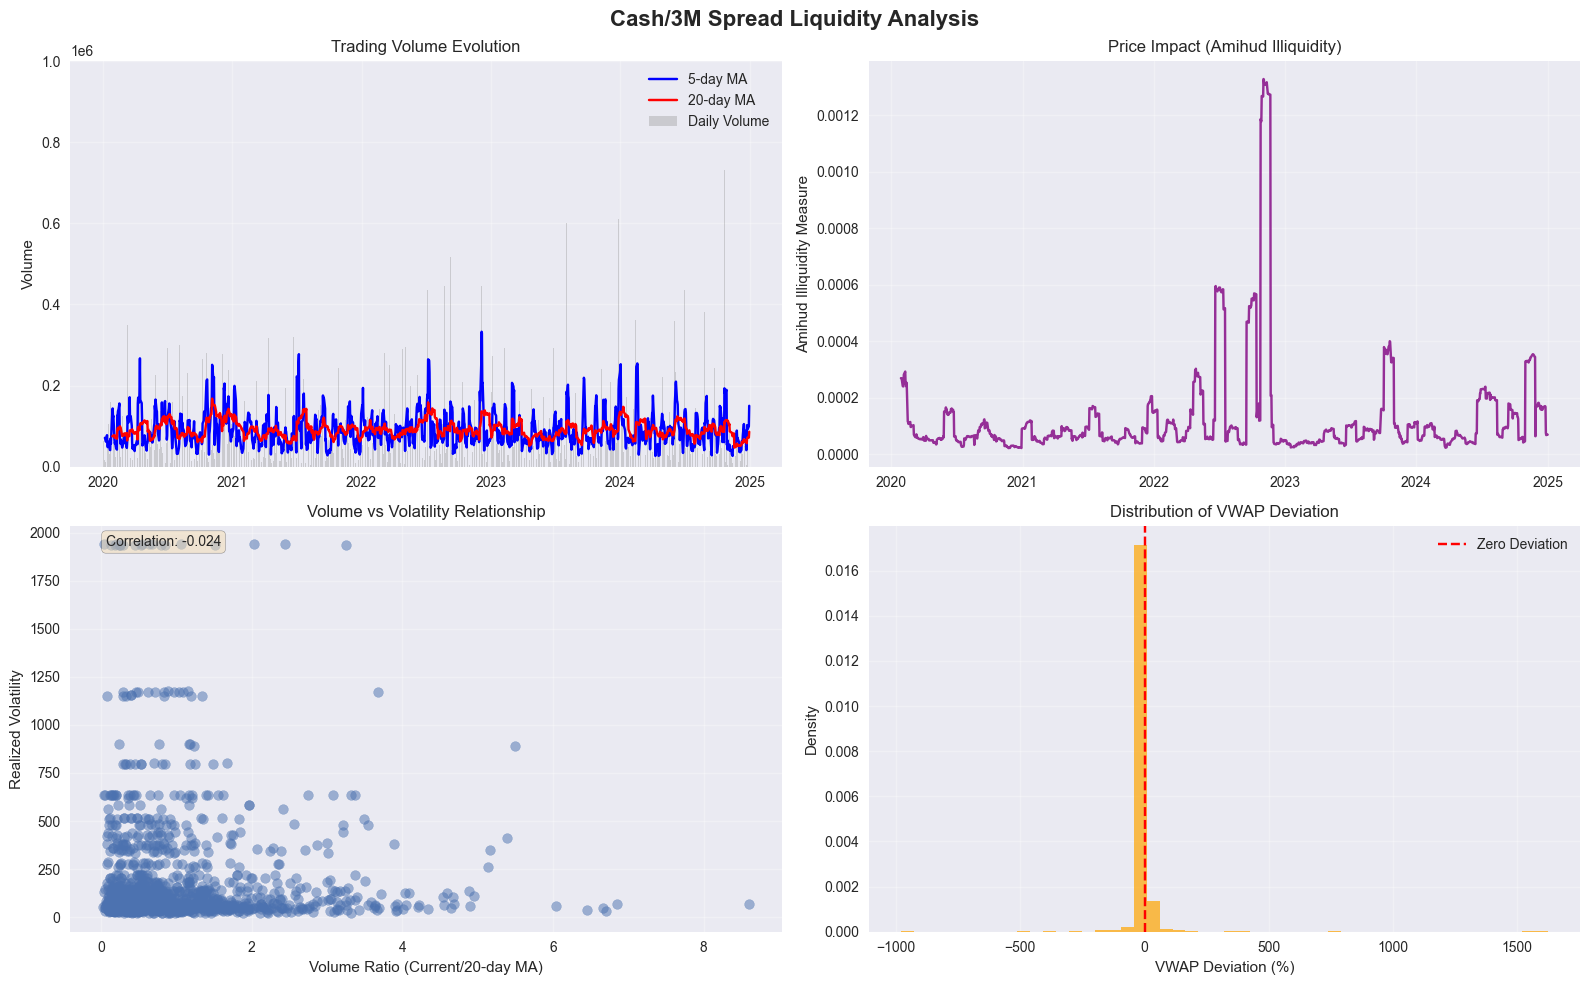

In [7]:
# 流動性分析の可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Cash/3M Spread Liquidity Analysis', fontsize=16, fontweight='bold')

# 1. 出来高の推移
ax1 = axes[0, 0]
ax1.bar(data_liq.index, data_liq['total_volume'], alpha=0.3, color='gray', label='Daily Volume')
ax1.plot(data_liq.index, data_liq['volume_ma_5'], color='blue', label='5-day MA')
ax1.plot(data_liq.index, data_liq['volume_ma_20'], color='red', label='20-day MA')
ax1.set_ylabel('Volume')
ax1.set_title('Trading Volume Evolution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 流動性指標（Amihud）
ax2 = axes[0, 1]
ax2.plot(data_liq.index, data_liq['amihud_ma'], color='purple', alpha=0.8)
ax2.set_ylabel('Amihud Illiquidity Measure')
ax2.set_title('Price Impact (Amihud Illiquidity)')
ax2.grid(True, alpha=0.3)

# 3. 出来高とボラティリティの関係
ax3 = axes[1, 0]
scatter_data = data_liq[['volume_ratio', 'realized_vol']].dropna()
ax3.scatter(scatter_data['volume_ratio'], scatter_data['realized_vol'], alpha=0.5)
ax3.set_xlabel('Volume Ratio (Current/20-day MA)')
ax3.set_ylabel('Realized Volatility')
ax3.set_title('Volume vs Volatility Relationship')
ax3.grid(True, alpha=0.3)

# 相関係数を追加
corr = scatter_data['volume_ratio'].corr(scatter_data['realized_vol'])
ax3.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax3.transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. VWAP乖離の分布
ax4 = axes[1, 1]
vwap_dev_clean = data_liq['vwap_deviation'].dropna()
ax4.hist(vwap_dev_clean, bins=50, alpha=0.7, density=True, color='orange')
ax4.axvline(0, color='red', linestyle='--', label='Zero Deviation')
ax4.set_xlabel('VWAP Deviation (%)')
ax4.set_ylabel('Density')
ax4.set_title('Distribution of VWAP Deviation')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. ボラティリティと流動性の関係

In [8]:
# ボラティリティ・流動性の相互作用分析
def analyze_vol_liquidity_interaction(df):
    """ボラティリティと流動性の相互作用を分析"""
    analysis_df = df[['realized_vol', 'total_volume', 'volume_ratio', 'amihud_illiquidity']].dropna()
    
    # 相関分析
    correlations = analysis_df.corr()
    
    # ボラティリティレジーム分類
    vol_percentiles = analysis_df['realized_vol'].quantile([0.25, 0.5, 0.75])
    
    def classify_vol_regime(vol):
        if vol <= vol_percentiles[0.25]:
            return 'Low Vol'
        elif vol <= vol_percentiles[0.5]:
            return 'Normal Vol'
        elif vol <= vol_percentiles[0.75]:
            return 'High Vol'
        else:
            return 'Extreme Vol'
    
    analysis_df['vol_regime'] = analysis_df['realized_vol'].apply(classify_vol_regime)
    
    # レジーム別統計
    regime_stats = analysis_df.groupby('vol_regime').agg({
        'total_volume': ['mean', 'std'],
        'amihud_illiquidity': ['mean', 'std'],
        'realized_vol': 'count'
    })
    
    return correlations, regime_stats, analysis_df

# 分析実行
correlations, regime_stats, analysis_data = analyze_vol_liquidity_interaction(data_liq)

print("ボラティリティ・流動性相関行列:")
print(correlations)
print("\nボラティリティレジーム別統計:")
print(regime_stats)

ボラティリティ・流動性相関行列:
                    realized_vol  total_volume  volume_ratio  \
realized_vol            1.000000     -0.025837     -0.024440   
total_volume           -0.025837      1.000000      0.960953   
volume_ratio           -0.024440      0.960953      1.000000   
amihud_illiquidity      0.106018     -0.088431     -0.094201   

                    amihud_illiquidity  
realized_vol                  0.106018  
total_volume                 -0.088431  
volume_ratio                 -0.094201  
amihud_illiquidity            1.000000  

ボラティリティレジーム別統計:
             total_volume                amihud_illiquidity            \
                     mean            std               mean       std   
vol_regime                                                              
Extreme Vol  93700.516256   96970.003140           0.000265  0.001400   
High Vol     87252.997433   85530.805675           0.000119  0.000526   
Low Vol      97272.134925   99709.991464           0.000039  0.000060   
No

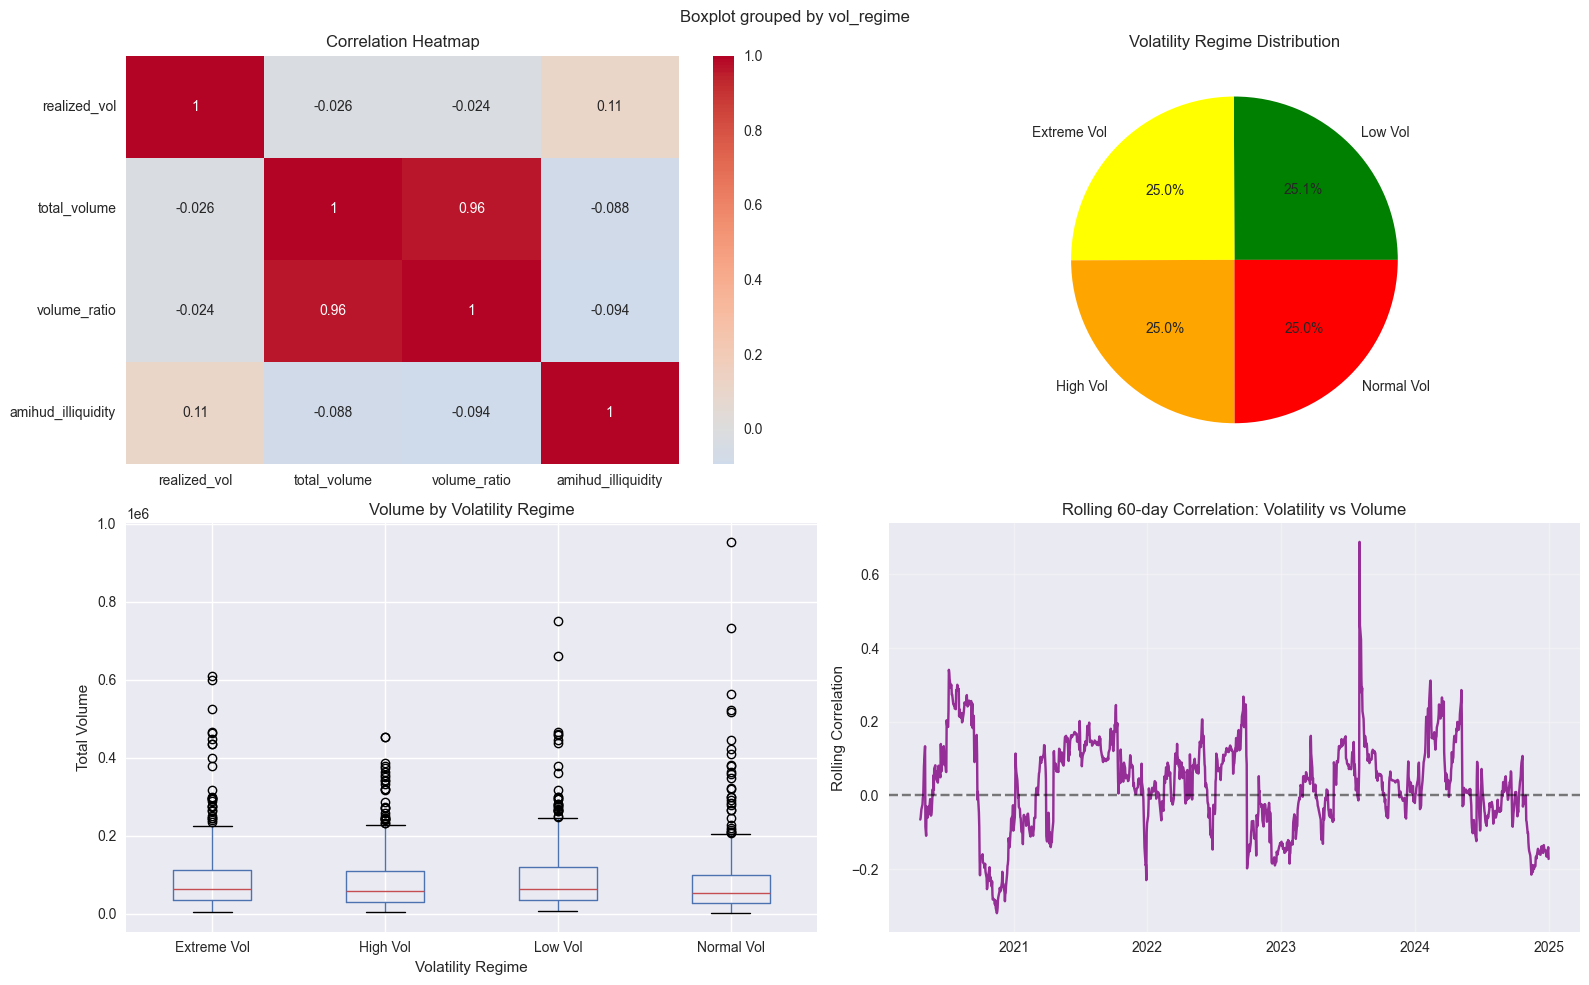

In [9]:
# 相互作用の可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Volatility-Liquidity Interaction Analysis', fontsize=16, fontweight='bold')

# 1. 相関ヒートマップ
ax1 = axes[0, 0]
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, ax=ax1)
ax1.set_title('Correlation Heatmap')

# 2. レジーム別分布
ax2 = axes[0, 1]
regime_counts = analysis_data['vol_regime'].value_counts()
colors = ['green', 'yellow', 'orange', 'red']
ax2.pie(regime_counts.values, labels=regime_counts.index, autopct='%1.1f%%', colors=colors)
ax2.set_title('Volatility Regime Distribution')

# 3. レジーム別出来高
ax3 = axes[1, 0]
analysis_data.boxplot(column='total_volume', by='vol_regime', ax=ax3)
ax3.set_xlabel('Volatility Regime')
ax3.set_ylabel('Total Volume')
ax3.set_title('Volume by Volatility Regime')

# 4. 動的相関
ax4 = axes[1, 1]
window = 60
rolling_corr = data_liq['realized_vol'].rolling(window=window).corr(data_liq['total_volume'])
ax4.plot(rolling_corr.index, rolling_corr, color='purple', alpha=0.8)
ax4.axhline(0, color='black', linestyle='--', alpha=0.5)
ax4.set_ylabel('Rolling Correlation')
ax4.set_title(f'Rolling {window}-day Correlation: Volatility vs Volume')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. リスク指標の開発

In [10]:
# 統合リスク指標の開発
def develop_risk_indicators(df):
    """スプレッド取引用の統合リスク指標を開発"""
    risk_df = df.copy()
    
    # 1. Value at Risk (VaR) - Historical Method
    confidence_levels = [0.95, 0.99]
    for conf in confidence_levels:
        risk_df[f'VaR_{int(conf*100)}'] = risk_df['spread_change'].rolling(window=252).quantile(1-conf)
    
    # 2. Expected Shortfall (CVaR)
    def calculate_cvar(returns, confidence=0.95):
        var = returns.quantile(1-confidence)
        return returns[returns <= var].mean()
    
    risk_df['CVaR_95'] = risk_df['spread_change'].rolling(window=252).apply(lambda x: calculate_cvar(x, 0.95))
    
    # 3. Volatility-Adjusted Spread (VAS)
    risk_df['VAS'] = risk_df['spread_price'] / (risk_df['realized_vol'] + 0.0001)  # 小さな定数を追加してゼロ除算を防ぐ
    
    # 4. Liquidity-Adjusted Risk Score (LARS)
    # ボラティリティと流動性を組み合わせたリスクスコア
    risk_df['vol_zscore'] = (risk_df['realized_vol'] - risk_df['realized_vol'].rolling(252).mean()) / risk_df['realized_vol'].rolling(252).std()
    risk_df['liq_zscore'] = (risk_df['amihud_illiquidity'] - risk_df['amihud_illiquidity'].rolling(252).mean()) / risk_df['amihud_illiquidity'].rolling(252).std()
    risk_df['LARS'] = (risk_df['vol_zscore'] + risk_df['liq_zscore']) / 2
    
    # 5. Regime Risk Indicator
    risk_df['regime_risk'] = 'Normal'
    risk_df.loc[risk_df['LARS'] > 1, 'regime_risk'] = 'Elevated'
    risk_df.loc[risk_df['LARS'] > 2, 'regime_risk'] = 'High'
    risk_df.loc[risk_df['LARS'] < -1, 'regime_risk'] = 'Low'
    
    return risk_df

# リスク指標の計算
data_risk = develop_risk_indicators(data_liq)

print("リスク指標統計:")
print(data_risk[['VaR_95', 'VaR_99', 'CVaR_95', 'LARS']].describe())
print("\nリスクレジーム分布:")
print(data_risk['regime_risk'].value_counts())

リスク指標統計:
            VaR_95       VaR_99      CVaR_95         LARS
count  1053.000000  1053.000000  1053.000000  1034.000000
mean   -318.013400  -426.921399  -388.403924     0.138579
std      31.840827    50.395224    42.936647     0.978176
min    -402.866567  -539.509747  -484.156952    -0.862114
25%    -336.226318  -456.489279  -427.424507    -0.380071
50%    -317.444653  -408.538870  -373.748952    -0.232511
75%    -295.910734  -391.815497  -359.209830     0.192252
max    -248.810790  -347.398834  -306.918200     9.225503

リスクレジーム分布:
regime_risk
Normal      1146
Elevated     120
High          39
Name: count, dtype: int64


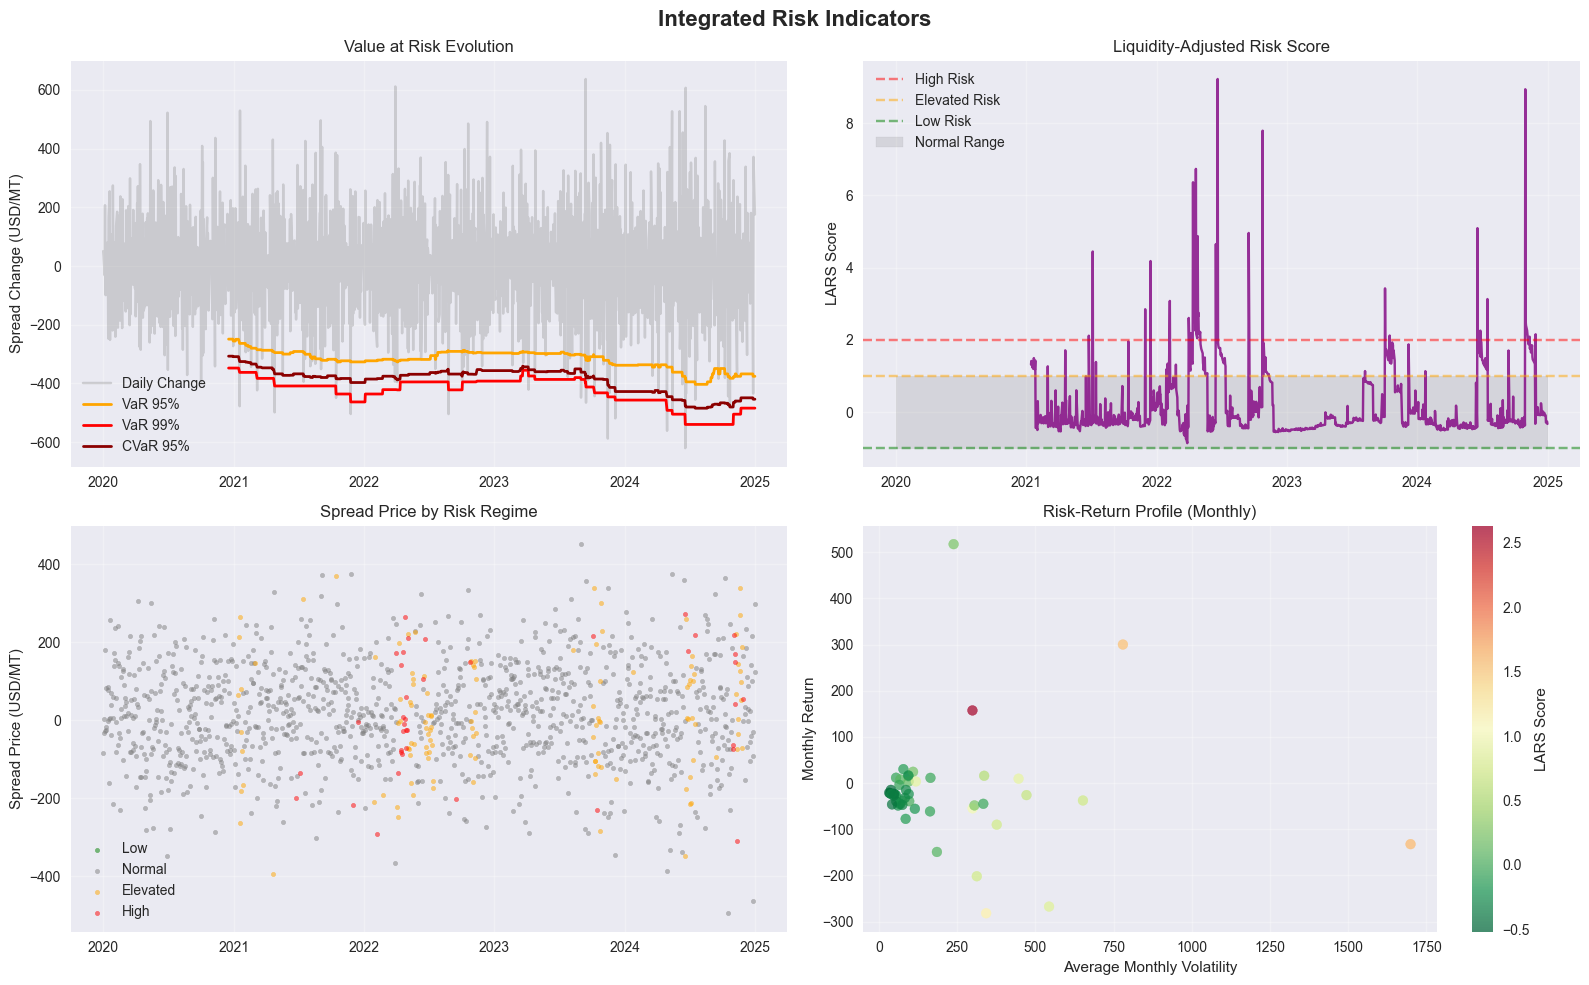

In [11]:
# リスク指標の可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Integrated Risk Indicators', fontsize=16, fontweight='bold')

# 1. VaRとCVaRの推移
ax1 = axes[0, 0]
ax1.plot(data_risk.index, data_risk['spread_change'], color='gray', alpha=0.3, label='Daily Change')
ax1.plot(data_risk.index, data_risk['VaR_95'], color='orange', label='VaR 95%', linewidth=2)
ax1.plot(data_risk.index, data_risk['VaR_99'], color='red', label='VaR 99%', linewidth=2)
ax1.plot(data_risk.index, data_risk['CVaR_95'], color='darkred', label='CVaR 95%', linewidth=2)
ax1.set_ylabel('Spread Change (USD/MT)')
ax1.set_title('Value at Risk Evolution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. LARS（統合リスクスコア）
ax2 = axes[0, 1]
ax2.plot(data_risk.index, data_risk['LARS'], color='purple', alpha=0.8)
ax2.axhline(2, color='red', linestyle='--', alpha=0.5, label='High Risk')
ax2.axhline(1, color='orange', linestyle='--', alpha=0.5, label='Elevated Risk')
ax2.axhline(-1, color='green', linestyle='--', alpha=0.5, label='Low Risk')
ax2.fill_between(data_risk.index, -1, 1, alpha=0.2, color='gray', label='Normal Range')
ax2.set_ylabel('LARS Score')
ax2.set_title('Liquidity-Adjusted Risk Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. リスクレジーム時系列
ax3 = axes[1, 0]
regime_colors = {'Low': 'green', 'Normal': 'gray', 'Elevated': 'orange', 'High': 'red'}
for regime, color in regime_colors.items():
    mask = data_risk['regime_risk'] == regime
    ax3.scatter(data_risk.index[mask], data_risk['spread_price'][mask], 
               color=color, alpha=0.5, label=regime, s=10)
ax3.set_ylabel('Spread Price (USD/MT)')
ax3.set_title('Spread Price by Risk Regime')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. リスク・リターンプロファイル
ax4 = axes[1, 1]
# 月次集計
monthly_data = data_risk.resample('M').agg({
    'spread_return': 'sum',  # 月次リターン
    'realized_vol': 'mean',  # 平均ボラティリティ
    'LARS': 'mean'  # 平均リスクスコア
}).dropna()

scatter = ax4.scatter(monthly_data['realized_vol'], monthly_data['spread_return'], 
                     c=monthly_data['LARS'], cmap='RdYlGn_r', alpha=0.7, s=50)
ax4.set_xlabel('Average Monthly Volatility')
ax4.set_ylabel('Monthly Return')
ax4.set_title('Risk-Return Profile (Monthly)')
plt.colorbar(scatter, ax=ax4, label='LARS Score')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. まとめと実践的示唆

In [12]:
# 分析結果のサマリー
def generate_analysis_summary(df):
    """分析結果の総合サマリーを生成"""
    summary = {}
    
    # ボラティリティ統計
    summary['vol_stats'] = {
        '平均ボラティリティ': df['realized_vol'].mean(),
        'ボラティリティ標準偏差': df['realized_vol'].std(),
        '最大ボラティリティ': df['realized_vol'].max(),
        '最小ボラティリティ': df['realized_vol'].min()
    }
    
    # 流動性統計
    summary['liquidity_stats'] = {
        '平均出来高': df['total_volume'].mean(),
        '出来高変動係数': df['total_volume'].std() / df['total_volume'].mean(),
        '平均Amihud指標': df['amihud_illiquidity'].mean()
    }
    
    # リスク統計
    summary['risk_stats'] = {
        '95% VaR': df['VaR_95'].mean(),
        '99% VaR': df['VaR_99'].mean(),
        '95% CVaR': df['CVaR_95'].mean(),
        '高リスク日数割合': (df['regime_risk'] == 'High').sum() / len(df)
    }
    
    # 相関関係
    summary['correlations'] = {
        'ボラティリティ・出来高相関': df['realized_vol'].corr(df['total_volume']),
        'スプレッド・ボラティリティ相関': df['spread_price'].corr(df['realized_vol'])
    }
    
    return summary

# サマリー生成
analysis_summary = generate_analysis_summary(data_risk.dropna())

print("===== Cash/3Mスプレッド ボラティリティ・流動性分析サマリー =====")
print("\n【ボラティリティ統計】")
for key, value in analysis_summary['vol_stats'].items():
    print(f"{key}: {value:.4f}")

print("\n【流動性統計】")
for key, value in analysis_summary['liquidity_stats'].items():
    print(f"{key}: {value:.4f}")

print("\n【リスク統計】")
for key, value in analysis_summary['risk_stats'].items():
    print(f"{key}: {value:.4f}")

print("\n【相関関係】")
for key, value in analysis_summary['correlations'].items():
    print(f"{key}: {value:.4f}")

===== Cash/3Mスプレッド ボラティリティ・流動性分析サマリー =====

【ボラティリティ統計】
平均ボラティリティ: 215.7029
ボラティリティ標準偏差: 364.0264
最大ボラティリティ: 1940.1762
最小ボラティリティ: 20.0177

【流動性統計】
平均出来高: 82937.3095
出来高変動係数: 1.1397
平均Amihud指標: 0.0001

【リスク統計】
95% VaR: -318.3275
99% VaR: -427.3472
95% CVaR: -388.6157
高リスク日数割合: 0.0447

【相関関係】
ボラティリティ・出来高相関: -0.0581
スプレッド・ボラティリティ相関: 0.0409


In [13]:
# 実践的な取引推奨事項
print("\n===== 実践的な取引推奨事項 =====")
print("\n1. ボラティリティベースの戦略:")
print("   - 低ボラティリティ期: スプレッド拡大戦略（平均回帰）")
print("   - 高ボラティリティ期: リスク削減、ポジション縮小")
print("   - ボラティリティ急上昇時: 新規エントリー回避")

print("\n2. 流動性考慮事項:")
print("   - 出来高が20日平均の50%以下: 取引回避")
print("   - Amihud指標上昇時: スリッページリスク増大に注意")
print("   - 月末・四半期末: 流動性低下に備える")

print("\n3. 統合リスク管理:")
print("   - LARS > 2: ポジション削減または解消")
print("   - LARS < -1: 取引機会の可能性")
print("   - VaR基準: ポジションサイズを95%VaRの2倍以内に制限")

print("\n4. 最適な取引タイミング:")
print("   - ボラティリティ低下＋流動性改善時")
print("   - スプレッドがVWAPから大きく乖離時")
print("   - リスクレジームが'Normal'または'Low'の期間")

print("\n5. ポジション管理:")
current_vol = data_risk['realized_vol'].iloc[-1]
current_lars = data_risk['LARS'].iloc[-1]
print(f"   - 現在のボラティリティ: {current_vol:.4f}")
print(f"   - 現在のLARSスコア: {current_lars:.4f}")
if current_lars > 1:
    print("   → リスク上昇中: ポジション縮小推奨")
elif current_lars < -0.5:
    print("   → リスク低下: 取引機会の可能性")
else:
    print("   → 通常リスク水準: 標準的なポジション管理")


===== 実践的な取引推奨事項 =====

1. ボラティリティベースの戦略:
   - 低ボラティリティ期: スプレッド拡大戦略（平均回帰）
   - 高ボラティリティ期: リスク削減、ポジション縮小
   - ボラティリティ急上昇時: 新規エントリー回避

2. 流動性考慮事項:
   - 出来高が20日平均の50%以下: 取引回避
   - Amihud指標上昇時: スリッページリスク増大に注意
   - 月末・四半期末: 流動性低下に備える

3. 統合リスク管理:
   - LARS > 2: ポジション削減または解消
   - LARS < -1: 取引機会の可能性
   - VaR基準: ポジションサイズを95%VaRの2倍以内に制限

4. 最適な取引タイミング:
   - ボラティリティ低下＋流動性改善時
   - スプレッドがVWAPから大きく乖離時
   - リスクレジームが'Normal'または'Low'の期間

5. ポジション管理:
   - 現在のボラティリティ: 124.2799
   - 現在のLARSスコア: -0.3297
   → 通常リスク水準: 標準的なポジション管理
